In [2]:
!nvidia-smi

Sat Aug 19 07:16:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# !git clone https://github.com/rohit-krish/Deeplex.git
%cd Deeplex


/content/Deeplex


In [4]:
import numpy as np

from sklearn.datasets import load_iris
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sb

from deeplex import nn, optim
from deeplex.nn import functional as F
from deeplex.engine import Tensor

plt.style.use(plt.style.available[11])


### Load the data

In [5]:
iris = load_iris()

X = iris.data
y = iris.target

# one-hot encode
Y = np.empty((len(y), len(iris.target_names)))
for i, t in enumerate(y):
    row = np.zeros((len(iris.target_names)))
    row[t] = 1
    Y[i] = row

X = Tensor(X)
Y = Tensor(Y)

X.shape, Y.shape

((150, 4), (150, 3))

### Define Model

In [6]:
class Model(nn.Module):
    def __init__(self, n_in, n_out, device):
        super().__init__(device)
        self.l1 = nn.Linear(n_in, 15, device=device)
        self.l2 = nn.Linear(15, 10, device=device)
        self.l3 = nn.Linear(10, n_out, device=device)

    def __call__(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.softmax(self.l3(x), axis=1)
        return x


### Training

In [8]:
device = 'cuda'
losses = []

X.to(device)
Y.to(device)

model = Model(4, 3, device)

lr = .01
n_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=lr, device=device)

loop = tqdm(range(n_epochs))

for epoch_i in loop:
    yHat = model(X)
    loss = F.MSELoss(Y, yHat)

    model.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.to('cpu').data)
    loop.set_postfix(loss=loss.to('cpu').data)


100%|██████████| 200/200 [00:01<00:00, 141.13it/s, loss=0.027181247]


### Evaluation

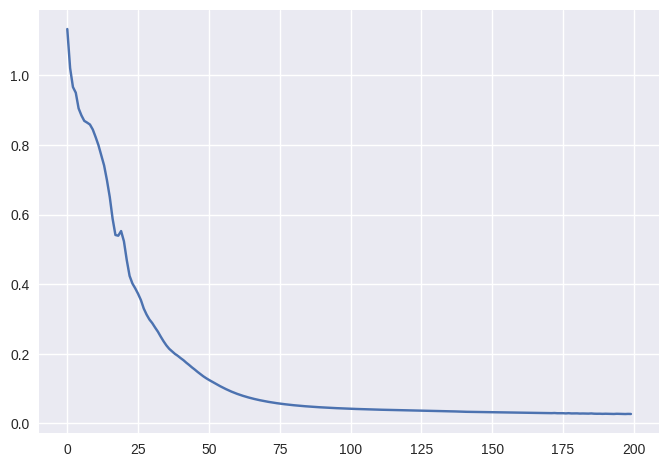

In [9]:
plt.plot(losses)
plt.show()


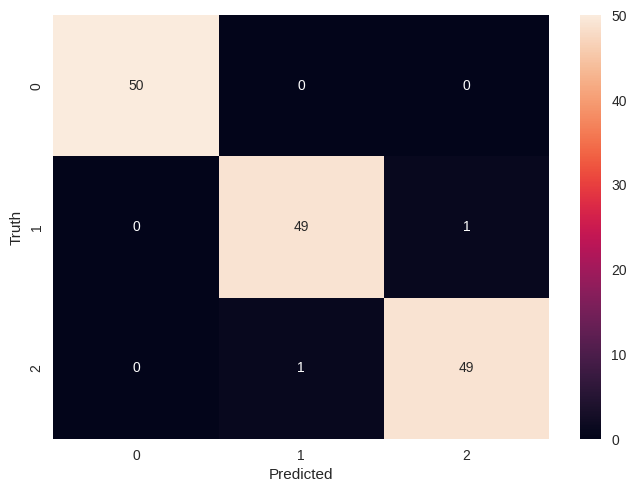

In [10]:
preds = model(X).to('cpu').data
preds = np.argmax(preds, axis=1)

truth = np.argmax(Y.to('cpu').data, axis=1)

cmap = confusion_matrix(truth, preds)
sb.heatmap(cmap, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()


In [11]:
print(classification_report(truth, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.98      0.98        50
           2       0.98      0.98      0.98        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

